In [1]:
import tensorflow as tf
from tensorflow import keras
import collections
import random
import time
import zipfile
import math
import matplotlib.pyplot as plt

from d2l.tensorflow import config

config.setup('CPU')

## Preprocessing

### Tokenize

In [2]:
with zipfile.ZipFile('../data/ptb.zip', 'r') as f:
    raw_text = f.read('ptb.train.txt').decode("utf-8").lower()
sentences = [line.split() for line in raw_text.split('\n')]    
'# sentences: %d' % len(sentences)

'# sentences: 42069'

### Vocabulary

In [3]:
def expand(sentences):
    """Expand a list of token lists into a list of tokens"""
    return [tk for line in sentences for tk in line]

In [4]:
class Vocab:
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        token_freqs = sorted(counter.items(), key=lambda x: x[0])
        token_freqs.sort(key=lambda x: x[1], reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            special_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            self.unk = 0
            special_tokens = ['<unk>']
        tokens = [token for token, freq in token_freqs
                  if freq >= min_freq and token not in special_tokens]
        self.idx_to_token = []
        self.token_to_idx = dict()
        for token in special_tokens + tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        else:
            return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        else:
            return [self.idx_to_token[index] for index in indices]

In [5]:
vocab = Vocab(expand(sentences), min_freq=10)
'vocab size: %d' % len(vocab)

'vocab size: 6719'

### Subsampling

In [6]:
# Map low frequency words into <unk>
sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line] 
             for line in sentences]
# Count the frequency for each word
tokens = expand(sentences)
counter = collections.Counter(tokens)

In [7]:
def discard(token):
    p = 1 - math.sqrt(1e-4 / counter[token] * len(tokens))
    return random.uniform(0, 1) < p

subsampled = [[tk for tk in line if not discard(tk)] for line in sentences]

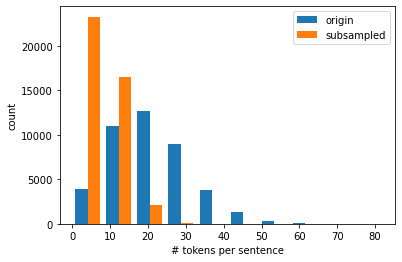

In [8]:
plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]] )
plt.xlabel('# tokens per sentence')
plt.ylabel('count')
plt.legend(['origin', 'subsampled'])
plt.plot();

In [9]:
def compare_counts(token):
    return '# of "%s": before=%d, after=%d' % (token, sum(
        [line.count(token) for line in sentences]), sum(
        [line.count(token) for line in subsampled]))

print(compare_counts('the'))
print(compare_counts('join'))

# of "the": before=50770, after=2077
# of "join": before=45, after=45


### Map words into indices

In [10]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[], [392, 32, 2132, 145, 275, 406], [5464, 3080, 1595]]

### Central target words and Context words

In [11]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a
        # "central target word - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [12]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


In [13]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
'# center-context pairs: %d' % len(all_centers)

'# center-context pairs: 352949'

### Negative Sampling

In [14]:
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights"""
    def __init__(self, sampling_weights):
        self.population = [*range(len(sampling_weights))]
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        
    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000
            )
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]
    
generator = RandomGenerator([2,3,4])
[generator.draw() for _ in range(10)]

[2, 2, 1, 2, 2, 1, 1, 1, 2, 2]

In [15]:
counter = collections.Counter(expand(corpus))
sampling_weights = [counter[i]**0.75 for i in range(len(counter))]

def get_negatives(all_contexts, sampling_weights, K):
    all_negatives = []
    generator = RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, sampling_weights, 5)

### Read into batches

In [16]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (
        tf.reshape([centers], (-1, 1)), 
        tf.convert_to_tensor(contexts_negatives),
        tf.convert_to_tensor(masks), 
        tf.convert_to_tensor(labels)
    )

In [17]:
x_1 = (1, [2,2], [3,3,3,3])
x_2 = (1, [2,2,2], [3,3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tf.Tensor(
[[1]
 [1]], shape=(2, 1), dtype=int32)
contexts_negatives = tf.Tensor(
[[2 2 3 3 3 3]
 [2 2 2 3 3 0]], shape=(2, 6), dtype=int32)
masks = tf.Tensor(
[[1 1 1 1 1 1]
 [1 1 1 1 1 0]], shape=(2, 6), dtype=int32)
labels = tf.Tensor(
[[1 1 0 0 0 0]
 [1 1 1 0 0 0]], shape=(2, 6), dtype=int32)


In [18]:
class ArrayDataset:
    """A dataset that combines multiple dataset-like objects, e.g.
    Datasets, lists, arrays, etc.

    The i-th sample is defined as `(x1[i], x2[i], ...)`.

    Parameters
    ----------
    *args : one or more dataset-like objects
        The data arrays.
    """
    def __init__(self, *args):
        assert len(args) > 0, "Needs at least 1 arrays"
        self._length = len(args[0])
        self._data = []
        for i, data in enumerate(args):
            assert len(data) == self._length, \
                "All arrays must have the same length; array[0] has length %d " \
                "while array[%d] has %d." % (self._length, i+1, len(data))
            self._data.append(data)
        self.handle = None

    def __getitem__(self, idx):
        if len(self._data) == 1:
            return self._data[0][idx]
        else:
            return tuple(data[idx] for data in self._data)

    def __len__(self):

        return self._length

In [19]:
class DataLoader:
    """Loads data from a dataset and returns mini-batches of data."""
    def __init__(self, dataset, batch_size, batch_fn):
        self._dataset = dataset
        self._batch_size = batch_size
        self._batch_fn = batch_fn
        self._length = len(dataset)
        self._current = -1
    
    def __next__(self):
        self._current += 1
        self._current %= self._length // self._batch_size + 1
        return batchify(
            zip(*self._dataset[self._current * self._batch_size: (1 + self._current) * self._batch_size])
        )
    
    def __iter__(self):
        return self.__next__()

In [20]:
# batch_size = 512
# dataset = ArrayDataset(all_centers, all_contexts, all_negatives)
# data_iter = DataLoader(dataset, batch_size, batchify)

# for batch in data_iter:
#     for name, data in zip(names, batch):
#         print(name, 'shape:', data.shape)
#     break

## Embedding layer

In [21]:
embed = keras.layers.Embedding(input_dim=20, output_dim=4)

x = tf.convert_to_tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 0.00255146, -0.02037088, -0.04176999, -0.03082113],
        [-0.00954988, -0.03162584, -0.01954601, -0.04147284],
        [ 0.04287783,  0.03077053,  0.0271712 , -0.01415782]],

       [[-0.04266019,  0.01479881,  0.017849  ,  0.01184804],
        [ 0.02974094,  0.03179413, -0.04136872, -0.0441918 ],
        [ 0.00193019,  0.03051336,  0.01650471,  0.01494348]]],
      dtype=float32)>

### Mini-batch multiplication

In [22]:
X = tf.ones((2, 1, 4))
Y = tf.ones((2, 4, 6))
keras.backend.batch_dot(X, Y).shape

TensorShape([2, 1, 6])

## Skip-gram Model Forward Calculation

In [23]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = keras.backend.batch_dot(v, u)
    return pred

skip_gram(tf.ones((2,1)), tf.ones((2,4)), embed, embed).shape

TensorShape([2, 1, 4])